In [1]:
import torch
from datasets import load_dataset, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from config import load_config, get_model_name
config = load_config("vq_vae")

train_loader, test_loader, val_loader = load_dataset(config["data_params"])

model_name = get_model_name(config)

In [ ]:
from trainers import SuperTrainer, VAEModule

model = VAEModule(config['model_params'], model_name=config['model_name'])

from trainers import SuperTrainer
trainer = SuperTrainer(**config['trainer_params'], model_name=model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

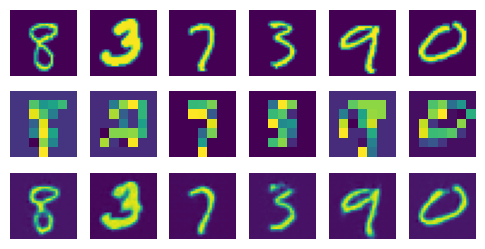

In [3]:
model = VAEModule.load_model_checkpoint(model_name)

from plotting import plot_samples_with_reconstruction_and_indices
plot_samples_with_reconstruction_and_indices(model, next(iter(test_loader)))

In [ ]:
from trainers import SuperTrainer, PixelCNNModule

pixel_cnn_model_name = "pixel_cnn_" + model_name
model = PixelCNNModule(vae_name=model_name)

from trainers import SuperTrainer
trainer = SuperTrainer(**config['trainer_params'], model_name = pixel_cnn_model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

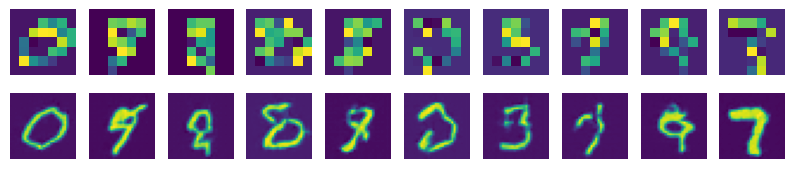

In [8]:
model = PixelCNNModule.load_model_checkpoint(pixel_cnn_model_name, vae_name = model_name)
from plotting import generate_indices_and_reconstruct
        
generate_indices_and_reconstruct(model)